In [1]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.cross_validation as cross_validation
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

/home/abhiraj/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def add_missing_dummy_columns(data, columns):
    missing_cols = set(columns) - set(data.columns)
    for col in missing_cols:
        data[col] = 0
        
def fix_columns(data, columns):  
    add_missing_dummy_columns(data, columns)
    assert(set(columns) - set(data.columns) == set())
    extra_cols = set(data.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    data = data[columns]
    return data

In [3]:
original_data = pd.read_csv('datasets/adultTrain.data',
        names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        engine='python',
        na_values="?")
original_data[:3]

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


In [4]:
original_test_data = pd.read_csv('datasets/adultTest.data',
        names=[
        "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Martial Status",
        "Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss",
        "Hours per week", "Country", "Target"],
        engine='python',
        na_values="?")
original_test_data['Target'] = original_test_data['Target'].str.replace('.','')
original_test_data[:3]

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K


# Analysis

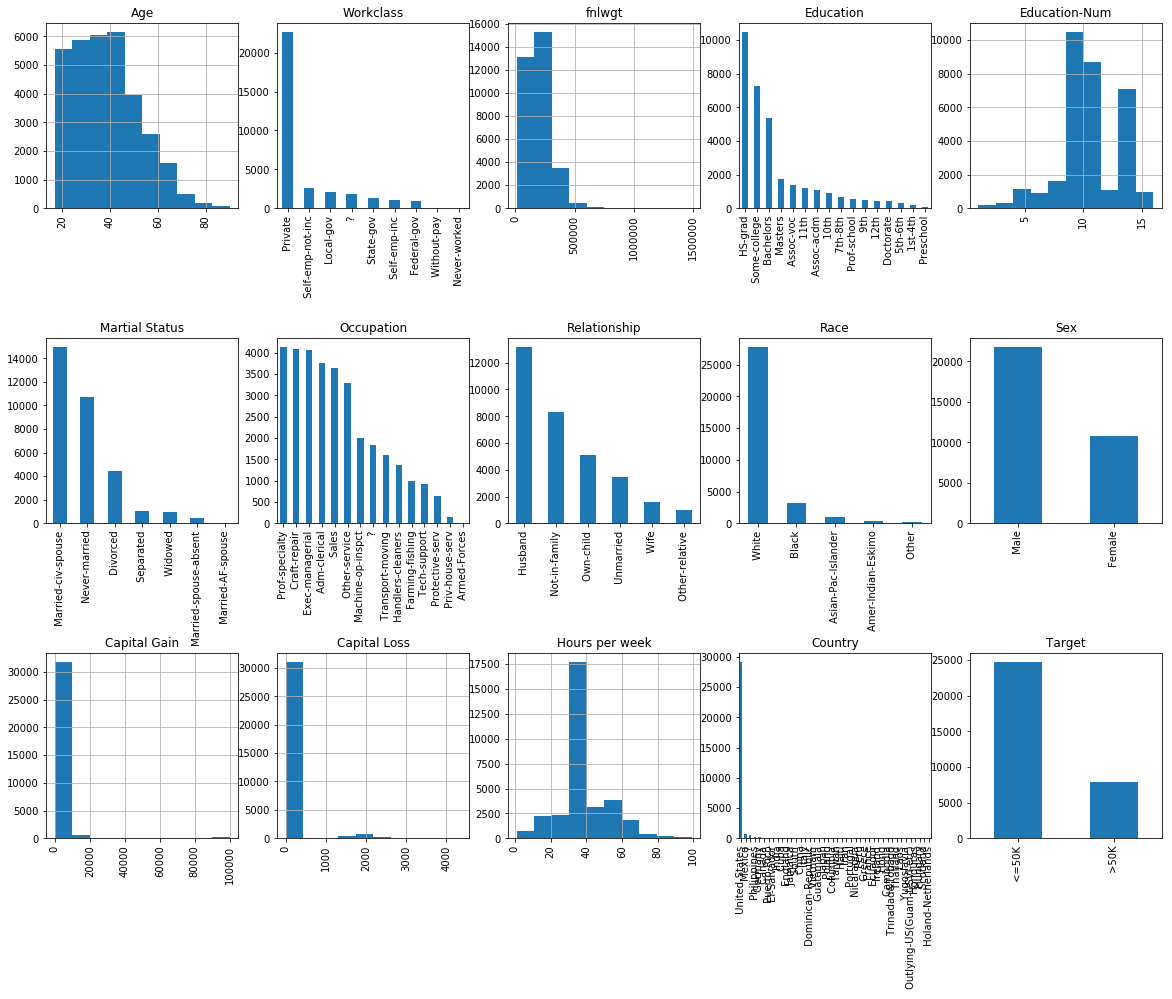

In [5]:
fig = plt.figure(figsize=(20,15))
cols = 5
rows = original_data.shape[1]/cols

for i, column in enumerate(original_data.columns):
  ax = fig.add_subplot(rows, cols, i+1)
  ax.set_title(column)
  if original_data.dtypes[column] == np.object:
    original_data[column].value_counts().plot(kind="bar", axes = ax)
  else:
    original_data[column].hist(axes = ax)
    plt.xticks(rotation = "vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)  

In [6]:
del original_test_data["Education"]
del original_data["Education"]

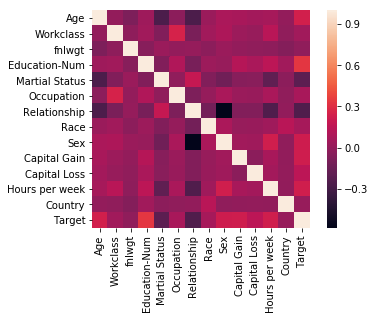

In [7]:
# Encode the categorical features as numbers
def number_encode_features(df, encoders = {}):
    result = df.copy()
    
    if encoders:
      for column in result.columns:
          if result.dtypes[column] == np.object:
              result[column] = encoders[column].fit_transform(result[column])
    else:
      for column in result.columns:
          if result.dtypes[column] == np.object:
              encoders[column] = preprocessing.LabelEncoder()
              result[column] = encoders[column].fit_transform(result[column])
    return result, encoders

# Calculate the correlation and plot it
encoded_data, _ = number_encode_features(original_data)
sns.heatmap(encoded_data.corr(), square=True)
plt.show()

# SVM

In [8]:
print(':::::MODEL:SVM::::::')
encoded_data, encoders = number_encode_features(original_data)

:::::MODEL:SVM::::::


In [9]:
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(encoded_data.drop("Target", axis = 1), 
                                                                     encoded_data["Target"], train_size=0.70)
scaler = preprocessing.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = scaler.transform(X_test)

__TRAINING DATASET__
C:1 
F1 score: 0.637320
accuracy: 0.848193


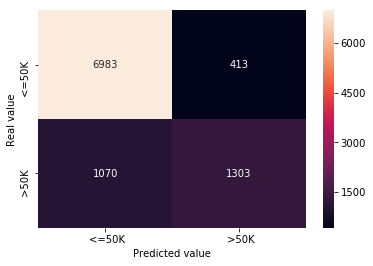

_________________________________________


In [10]:
print('__TRAINING DATASET__')
from sklearn import svm
C=1
clf = svm.SVC(kernel='rbf',C=C)
clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
cm = metrics.confusion_matrix(Y_test, Y_pred)

plt.figure()
sns.heatmap(cm, annot = True, fmt = "d", 
            xticklabels=encoders["Target"].classes_, 
            yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print ("C:%d \nF1 score: %f\naccuracy: %f" % (int(C),            \
                              skl.metrics.f1_score(Y_test, Y_pred),       \
                              skl.metrics.accuracy_score(Y_test, Y_pred)))
plt.show()
print("_________________________________________")

#### Validation

In [11]:
encoded_test_data, encoders = number_encode_features(original_test_data, encoders)

In [12]:
X_test,Y_test = [encoded_test_data.drop("Target", axis = 1), encoded_test_data["Target"]]
X_test = scaler.transform(X_test)

__TEST DATASET__
C:1 
F1 score: 0.627971
accuracy: 0.850009


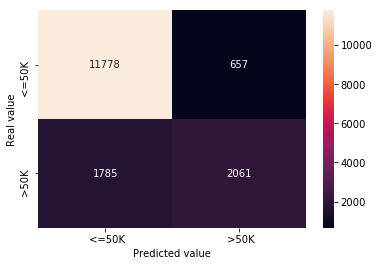

_________________________________________


In [13]:
print('__TEST DATASET__')
Y_pred = clf.predict(X_test)
cm = metrics.confusion_matrix(Y_test, Y_pred)

plt.figure()
sns.heatmap(cm, annot = True, fmt = "d", 
            xticklabels=encoders["Target"].classes_, 
            yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print ("F1 score: %f\naccuracy: %f" % (skl.metrics.f1_score(y_test, y_pred),       \
                              skl.metrics.accuracy_score(y_test, y_pred)))
plt.show()
print("_________________________________________")

## OneHot Encoding for KNN and NN

In [14]:
binary_data = pd.get_dummies(original_data)
binary_data[:3]

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Target_ <=50K,Target_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [15]:
binary_test_data = pd.get_dummies(original_test_data)
binary_test_data[:3]

,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass_ ?,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Target_ <=50K,Target_ >50K
0,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,28,336951,12,0,0,40,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1


In [16]:
binary_test_data = fix_columns(binary_test_data, binary_data.columns)

In [17]:
binary_data["Target"] = binary_data["Target_ >50K"]
del binary_data["Target_ <=50K"]
del binary_data["Target_ >50K"]

In [18]:
binary_test_data["Target"] = binary_test_data["Target_ >50K"]
del binary_test_data["Target_ <=50K"]
del binary_test_data["Target_ >50K"]

In [19]:
split_portion = 0.9
train_len = int(binary_data.shape[0]*split_portion)
X_train, Y_train, X_test, Y_test = [
  binary_data.drop(['Target'],axis = 1)[:train_len], \
  binary_data['Target'][:train_len], \
  binary_data.drop(['Target'],axis = 1)[train_len:], \
  binary_data['Target'][train_len:] \
]

x_test, y_test = [binary_test_data.drop(['Target'],axis = 1),
                 binary_test_data['Target']]

# KNN

In [20]:
print(':::::MODEL:KNN::::::')
from sklearn.neighbors import KNeighborsClassifier

:::::MODEL:KNN::::::


__TRAINING DATASET__
i:17 
F1 score: 0.362573
accuracy: 0.799202


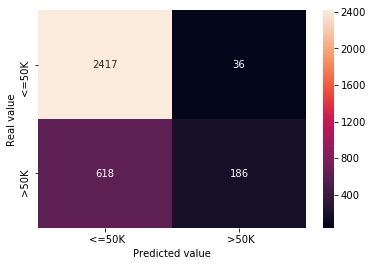

_________________________________________


In [21]:
print('__TRAINING DATASET__')

i = 17
KNN = KNeighborsClassifier(n_neighbors=i)
KNN.fit(X_train, Y_train)

Y_pred = KNN.predict(X_test)
cm = metrics.confusion_matrix(Y_test, Y_pred)

plt.figure()
sns.heatmap(cm, annot = True, fmt = "d", 
            xticklabels=encoders["Target"].classes_, 
            yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print ("i:%d \nF1 score: %f\naccuracy: %f" % (int(i),            \
                              skl.metrics.f1_score(Y_test, Y_pred),       \
                              skl.metrics.accuracy_score(Y_test, Y_pred)))
plt.show()
print("_________________________________________")

__TEST DATASET__
i:17 
F1 score: 0.338430
accuracy: 0.800688


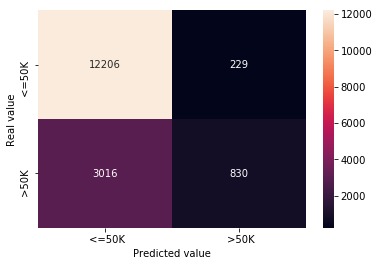

_________________________________________


In [22]:
print('__TEST DATASET__')

y_pred = KNN.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot = True, fmt = "d", 
            xticklabels=encoders["Target"].classes_, 
            yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print ("F1 score: %f\naccuracy: %f" % (skl.metrics.f1_score(y_test, y_pred),       \
                              skl.metrics.accuracy_score(y_test, y_pred)))
plt.show()
print("_________________________________________")

# Neural Net

In [23]:
split_portion = 0.7
train_len = int(binary_data.shape[0]*split_portion)
X_train, Y_train, X_test, Y_test = [
  binary_data.drop(['Target'],axis = 1)[:train_len], \
  binary_data['Target'][:train_len], \
  binary_data.drop(['Target'],axis = 1)[train_len:], \
  binary_data['Target'][train_len:] \
]

x_test, y_test = [binary_test_data.drop(['Target'],axis = 1),
                 binary_test_data['Target']]

In [24]:
print(':::::MODEL:NN:::::::')
from sklearn.neural_network import MLPClassifier

:::::MODEL:NN:::::::


In [25]:
X_train.shape

(22792, 92)

__TRAINING DATASET__
H_SIZE:60	j 
F1 score: 0.339315
accuracy: 0.792712


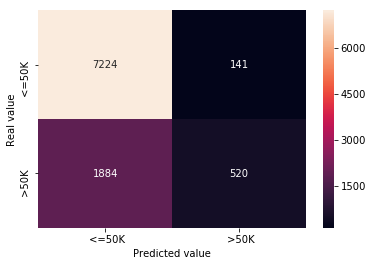

_________________________________________


In [39]:
print('__TRAINING DATASET__')


mlp = MLPClassifier(hidden_layer_sizes=(60))
mlp.fit(X_train, Y_train)

Y_pred = mlp.predict(X_test)
cm = metrics.confusion_matrix(Y_test, Y_pred)

plt.figure()
sns.heatmap(cm, annot = True, fmt = "d", 
            xticklabels=encoders["Target"].classes_, 
            yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")

f1 = skl.metrics.f1_score(Y_test, Y_pred)
accuracy = skl.metrics.accuracy_score(Y_test, Y_pred)

print ("H_SIZE:%s\tj \nF1 score: %f\naccuracy: %f" % ((60),f1,accuracy))
plt.show()
print("_________________________________________")

__TEST DATASET__
F1 score: 0.319049
accuracy: 0.796020


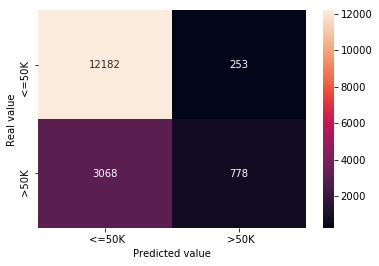

_________________________________________


In [40]:
print('__TEST DATASET__')

y_pred = mlp.predict(x_test)
cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(cm, annot = True, fmt = "d", 
            xticklabels=encoders["Target"].classes_, 
            yticklabels=encoders["Target"].classes_)
plt.ylabel("Real value")
plt.xlabel("Predicted value")
print ("F1 score: %f\naccuracy: %f" % (skl.metrics.f1_score(y_test, y_pred),       \
                              skl.metrics.accuracy_score(y_test, y_pred)))
plt.show()
print("_________________________________________")